# Figures for Keizer et al. (2023): "The acceleration of sea-level rise along the coast of the Netherlands started in the 1960s"

### Overview of this notebook
- Fig. 1: setting & pressure correlation (partly created in `obtain_pressure_gradient.ipynb`)
- Fig. 2: sea level time series
- Fig. 3: wind contribution to sea level rise
- Fig. 4: rates of sea level rise
- Fig. A1: Nodal effects on sea level
- Fig. B1: Rates of SLR of individual tide gauges
- Fig. C1: multidecadal variability correlation map
- Fig. C2 is created in `figures_MV.ipynb`

this notebook requires the `spectrum` package (in the `local_functions.py`)

In [16]:
import os
import regionmask
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
# import statsmodels.api as sm
# import matplotlib.ticker as mticker

from scipy.stats import norm, linregress

import local_functions as loc

# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

#%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [17]:
region = 'Netherlands' # Choose from 'Netherlands', 'Belgium', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden'
bootsize = 1000 # Choose from 100, 1000, 10000
output_dir = f'./outputs/'

### Read coordinate data

In [18]:
tg_coords = pd.read_csv(f'{output_dir}tg_coords.csv', index_col = 'station')
era5_coords = pd.read_csv(f'{output_dir}ERA5_coords.csv', index_col = 'station')
twcr_coords = pd.read_csv(f'{output_dir}20CR_coords.csv', index_col = 'station')

### Read surface pressure & sea level correlation coefficients

In [19]:
twcr_corr = xr.open_dataset(f'{output_dir}corr_20CR.nc').rename({'__xarray_dataarray_variable__': 'r'}).r

### Read SST correlation data

In [20]:
cobe_sst = xr.open_dataset(f'{output_dir}cobe_sst.nc')
cobe_lagged_na = pd.read_csv(f'{output_dir}cobe_lagged_corr_NearestPointAverage2.csv', index_col = 'lag')
cobe_lagged_pd = pd.read_csv(f'{output_dir}cobe_lagged_corr_PressureDifference.csv', index_col = 'lag')

### Read rates data

In [21]:
output_dir = f'./outputs/{region}/'

if os.path.exists(output_dir)==False:
    os.makedirs(output_dir)

if os.path.exists(output_dir+str(bootsize))==False:
    os.makedirs(output_dir+str(bootsize))

In [22]:
tg_df = pd.read_csv(f'{output_dir}data_tide_gauges.csv')

res_nr = pd.read_csv(f'{output_dir}results_NoRegressor.csv')
res_nt = pd.read_csv(f'{output_dir}results_NodalTide.csv')
res_na = pd.read_csv(f'{output_dir}results_NearestPointAverage2.csv')
res_pd = pd.read_csv(f'{output_dir}results_PressureDifference.csv')

for df in [tg_df, res_nr, res_nt, res_na, res_pd]:
    df.set_index('time', inplace=True)

In [23]:
rates_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_NoRegressor.csv')
rates_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_NodalTide.csv')
rates_na = pd.read_csv(f'{output_dir}{bootsize}/rates_NearestPointAverage2.csv')
rates_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_PressureDifference.csv')

rates_q_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NoRegressor.csv')
rates_q_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NodalTide.csv')
rates_q_na = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NearestPointAverage2.csv')
rates_q_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_PressureDifference.csv')

for df in [rates_nr, rates_nt, rates_na, rates_pd,
           rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd,]:
    df.set_index('time', inplace=True)

In [24]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_pd = rates_pd.std(axis=1)

In [25]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (velocity)', 
              'Trend, nodal tide and wind (pressure)']

short_names = ['$\it{Tr}$', '$\it{TrNt}$', '$\it{TrNtW}$', '$\it{TrNtPd}$']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(4)]

In [26]:
(rates_q_na['0.5'][2000]-rates_q_na['0.5'][1975])/25

0.05267854718089908

### Read data nodal tides

In [27]:
nodal = pd.read_csv(f'{output_dir}NodalTide.csv').set_index('time')
nodal_residuals = pd.read_csv(f'{output_dir}NodalTideResiduals.csv').set_index('time')

## Fig. 1: Overview maps

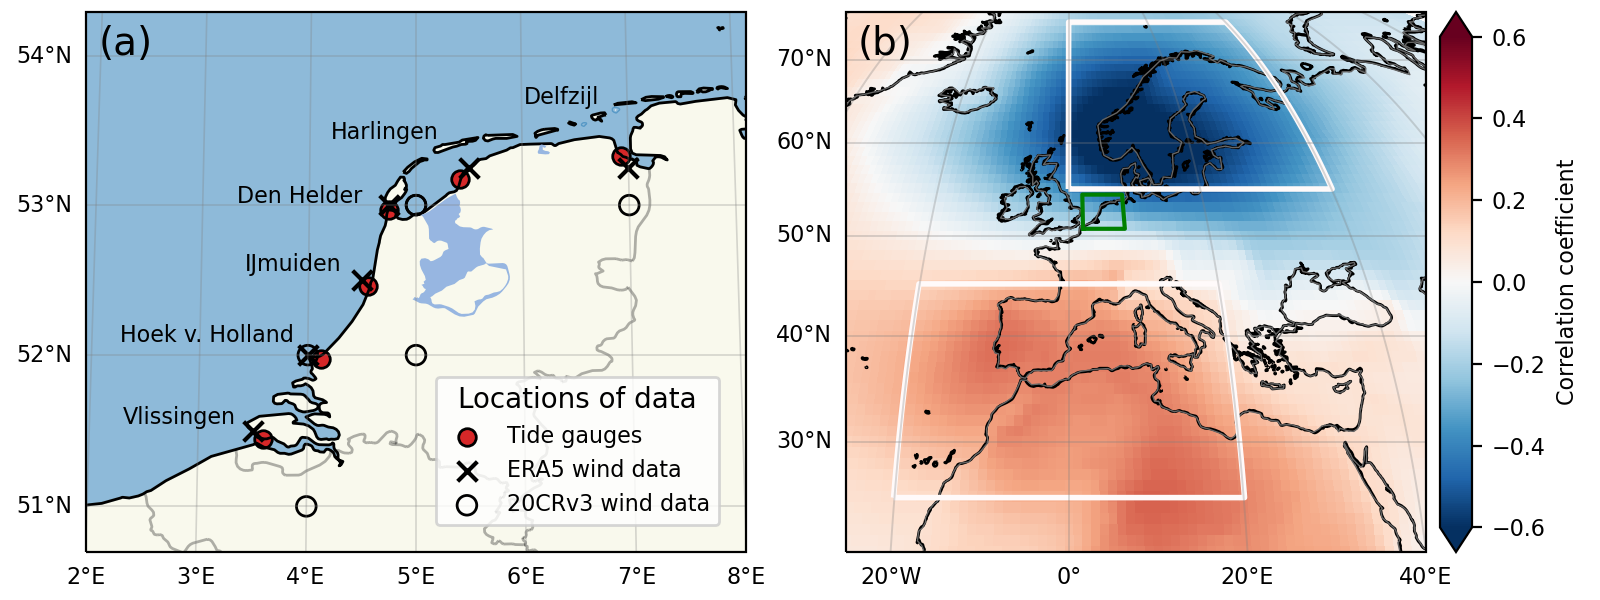

In [28]:
ex = (2,8,50.7,54.3)

f = plt.figure(figsize=(8,3))
fsize = 8

# (a) NL map: tide gauge stations, ERA5/20Cr points
ax0 = f.add_axes((.05,.08,.42,.9), projection=ccrs.Mollweide(central_longitude=5))
ax0.set_extent(ex)
ax0.coastlines()
ax0.add_feature(cf.BORDERS, alpha=.3)
ax0.add_feature(cf.OCEAN, color='C0', alpha=.5)
ax0.add_feature(cf.LAND, color='beige', alpha=.5)
ax0.add_feature(cf.LAKES)

gl0 = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   x_inline=False, y_inline=False,
                   xlocs=np.arange(-180,180,1), ylocs=np.arange(-90,90,1),
                   linewidth=.6, color='gray', alpha=0.3)

for i, station in enumerate(tg_coords.index):
    lat = tg_coords['lat'][station]
    lon = tg_coords['lon'][station]
    ax0.scatter(lon                        , lat                        , s=40, marker='o',
                transform=ccrs.PlateCarree(), color='tab:red', edgecolor = 'k', label = f'{station} ({round(lat,1)}, {round(lon,1)})')
    ax0.scatter(era5_coords['lon'][station], era5_coords['lat'][station], s=50, marker='x',
                transform=ccrs.PlateCarree(), color='k')
    ax0.scatter(twcr_coords['lon'][station], twcr_coords['lat'][station], s=50, marker='o',
                transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k')

# Add station names
props = {'fontsize':fsize, 'ha':'right', 'transform':ccrs.PlateCarree()}

ax0.text(tg_coords['lon']['Vlissingen']      -.25, tg_coords['lat']['Vlissingen']      +.1, 'Vlissingen'     , **props)
ax0.text(tg_coords['lon']['Hoek van Holland']-.25, tg_coords['lat']['Hoek van Holland']+.11, 'Hoek v. Holland', **props)
ax0.text(tg_coords['lon']['IJmuiden']        -.25, tg_coords['lat']['IJmuiden']        +.1 , 'IJmuiden'       , **props)
ax0.text(tg_coords['lon']['Den Helder']      -.25, tg_coords['lat']['Den Helder']      +.05, 'Den Helder'     , **props)
ax0.text(tg_coords['lon']['Harlingen']       -.2 , tg_coords['lat']['Harlingen']       +.27 , 'Harlingen'      , **props)
ax0.text(tg_coords['lon']['Delfzijl']        -.2 , tg_coords['lat']['Delfzijl']        +.35 , 'Delfzijl'       , **props)

ax0.legend(labels = ['Tide gauges', 'ERA5 wind data', '20CRv3 wind data'], title='Locations of data',
           loc=(0.53,.05), fontsize = fsize, fancybox=True, frameon = True)


# (b) pressure correlation map
ax1 = f.add_axes((.52,.08,.38,.9), projection=ccrs.Mollweide())
ax1.set_extent([-25,40,20,75])

corr_map = ax1.pcolormesh(twcr_corr.lon, twcr_corr.lat, twcr_corr.sel(station='Average'),
                          transform=ccrs.PlateCarree(),
                          vmin=-.6, vmax=.6, cmap='RdBu_r')
ax1.coastlines(resolution = '50m')

# outline of ax0 extent
ax1.plot([ex[0],ex[1],ex[1],ex[0],ex[0]], [ex[2],ex[2],ex[3],ex[3],ex[2]],
          transform=ccrs.PlateCarree(), color='green')

# correlation selection boxes
dang_coords_np = np.array([[-0.1, 54.9], [40.1, 54.9], [40.1, 75.1], [-0.1, 75.1]])
dang_coords_pp = np.array([[-20.1, 24.9], [20.1, 24.9], [20.1, 45.1], [-20.1, 45.1]])
dang_regions = regionmask.Regions([dang_coords_np, dang_coords_pp], numbers = [1,2], 
                                        names=["", ""], abbrevs=["NP", "PP"], 
                                        name="Dangendorf regions")
dang_regions.plot(ax=ax1, label='name', line_kws = {'color':'snow', 'lw':2}, 
                  text_kws = dict(bbox=dict(color="none"), fontsize = 15, color = 'snow'))

# grid
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   x_inline=False, y_inline=False,
                   xlocs=np.arange(-180,180,20), ylocs=np.arange(-90,90,10),
                   linewidth=.7, color='gray', alpha=0.3)
# gl1.left_labels = False


for gl in [gl0, gl1]:
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}
    gl.right_labels = False
    gl.top_labels = False

# (a/b) labels
ax0.text(0.02, 0.92, '(a)', size=14, transform=ax0.transAxes)
ax1.text(0.02, 0.92, '(b)', size=14, transform=ax1.transAxes)

# colorbar
cax = f.add_axes((.9,.08,.02,.9))
cb = plt.colorbar(corr_map, cax=cax, orientation="vertical", shrink = 0.5, extend = 'both')                                   
cb.set_label(label='Correlation coefficient', size=fsize)
cb.ax.tick_params(labelsize=fsize)

f.savefig('figures/Fig1.pdf')
f.savefig('figures/Fig1.png', dpi=600)


## Fig. 2: sea level time series

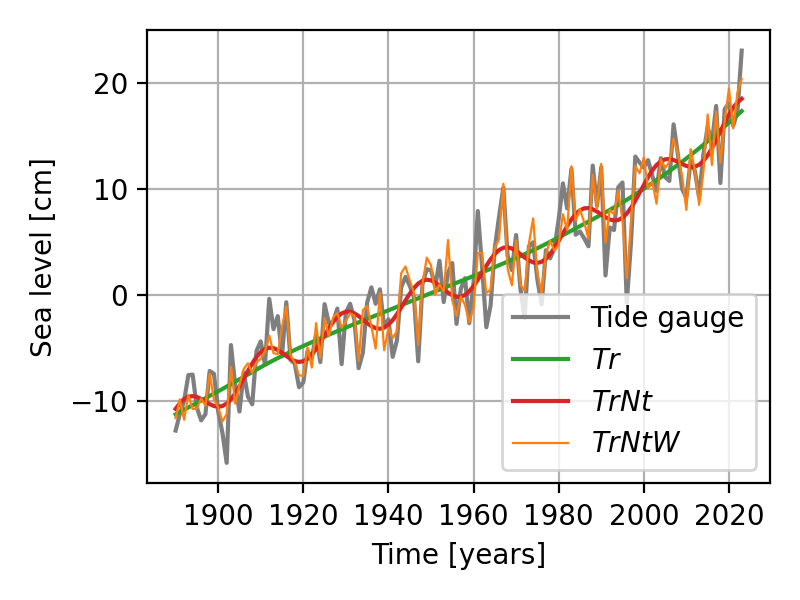

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_na.total.plot(label=short_names[2], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
# ax.grid(True)
ax.set_xticks(np.arange(1900,2021,20))
ax.grid(axis='x', which='major')
ax.grid(axis='y', which='major')
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/TideGauge_StatModels_W.pdf', dpi=150)
plt.savefig(f'./figures/Fig2.pdf', dpi=150)


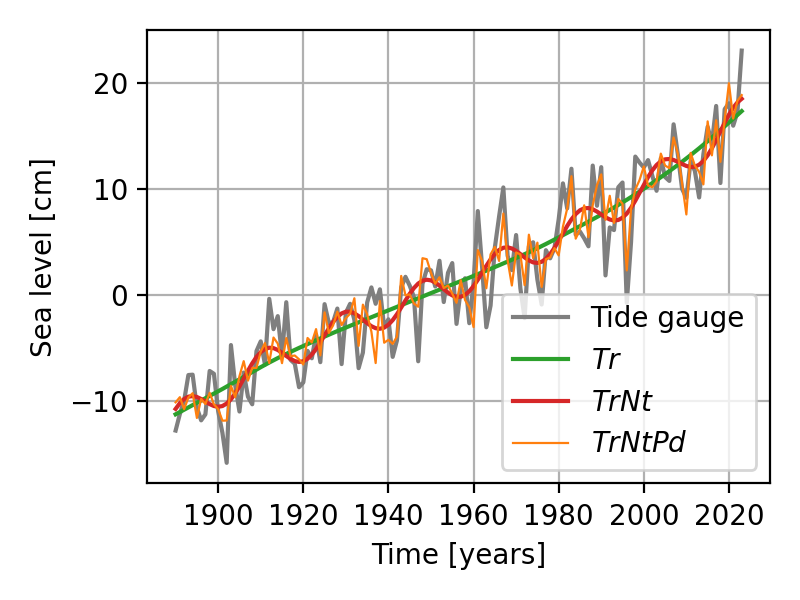

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_pd.total.plot(label=short_names[3], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
# ax.grid(True)
ax.set_xticks(np.arange(1900,2021,20))
ax.grid(axis='x', which='major')
ax.grid(axis='y', which='major')
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/TideGauge_StatModels_Pd.pdf', dpi=150)

## Fig. 3: Wind contribution to sea level

In [31]:
wind_rec = pd.read_csv(f'{output_dir}/WindInfluence.csv')
wind_rec.set_index('time', inplace=True)

In [32]:
# Estimate the linear trend for different periods

mid_point = int(len(wind_rec.index)/2)
print(mid_point)

lin_trend_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[mid_point:-1]).slope*10, 2)

lin_trend_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).slope*10, 2)

94


/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_28328/353944942.py:49: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


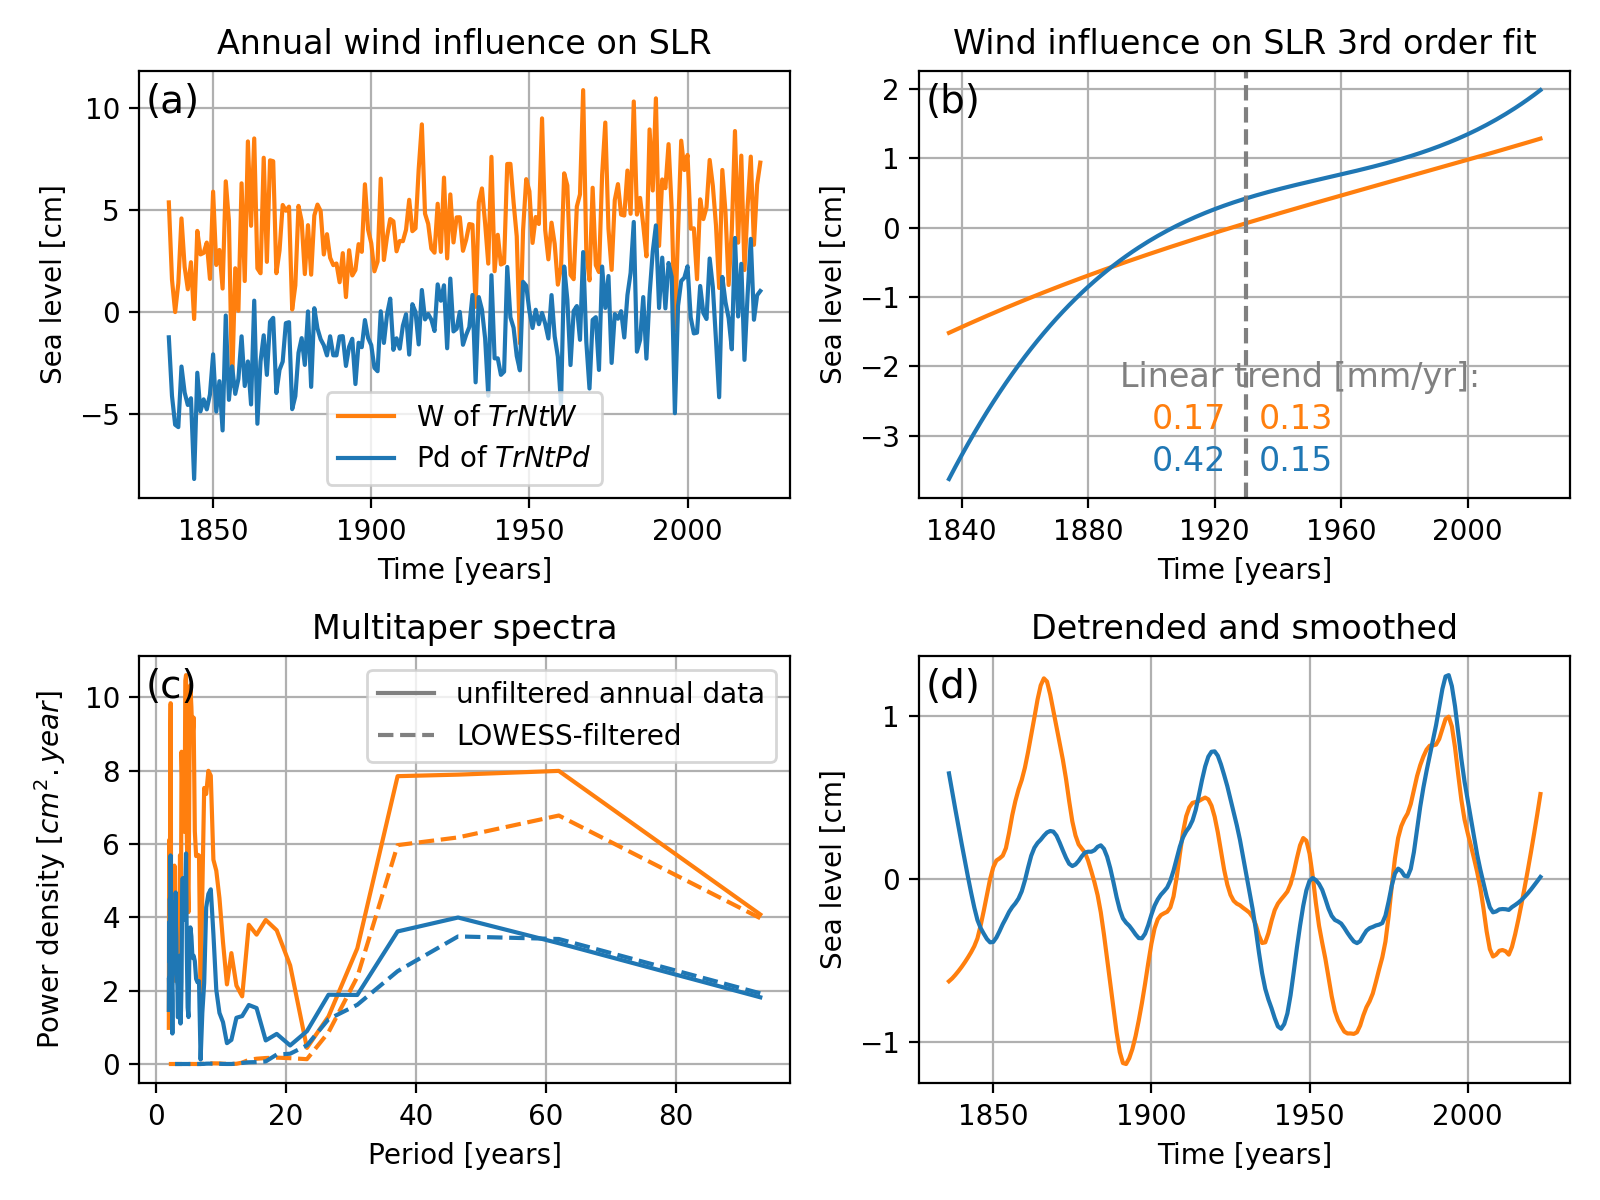

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(8,6)) #14, 10

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']


# Panel 1
wind_rec[['NearestPointAverage2', 'PressureDifference']].plot(ax=ax[0,0], color=[colors[2], colors[3]])

ax[0,0].legend(['W of $\it{TrNtW}$', 'Pd of $\it{TrNtPd}$'])
ax[0,0].set_title('Annual wind influence on SLR')
ax[0,0].set_ylabel('Sea level [cm]')
ax[0,0].set_xlabel('Time [years]')


# Panel 2
(wind_rec['NearestPointAverage2_trend']-wind_rec['NearestPointAverage2_trend'].mean() ).plot(ax=ax[0,1], color=colors[2])
(wind_rec['PressureDifference_trend']-wind_rec['PressureDifference_trend'].mean() ).plot(ax=ax[0,1], color=colors[3])                                                                                                          

ax[0,1].text(1900, -2.9, lin_trend_na1, size=12, color=colors[2])
ax[0,1].text(1934, -2.9, lin_trend_na2, size=12, color=colors[2])

ax[0,1].text(1900, -3.5, lin_trend_pd1, size=12, color=colors[3])
ax[0,1].text(1934, -3.5, lin_trend_pd2, size=12, color=colors[3])

ax[0,1].text(1890, -2.3, 'Linear trend [mm/yr]:', size=12, color='grey')

ax[0,1].axvline(x=wind_rec.index[mid_point], color='grey', linestyle='--')

ax[0,1].set_title('Wind influence on SLR 3rd order fit')
ax[0,1].set_ylabel('Sea level [cm]')
ax[0,1].set_xlabel('Time [years]')


ax[0,1].set_xticks(range(1840, 2020, 40))

'''
list_st = [1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000]
for st in list_st:
    avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
    ax[0,1].text(st+3, 0.55, avg_rate, size=12, color='grey')
    ax[0,1].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', linestyle='-')
ax[0,1].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')
'''

# Panel 3
xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2], linestyle = 'dashed')

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_dt'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3], linestyle = 'dashed')

l1, = ax[1,0].plot([],[], c='grey', label='unfiltered annual data')
l2, = ax[1,0].plot([],[], c='grey', ls='--', label='LOWESS-filtered')
ax[1,0].legend(handles=[l1,l2])

ax[1,0].set_title('Multitaper spectra')
ax[1,0].set_ylabel('Power density '+r'$[cm^2.year]$')
ax[1,0].set_xlabel('Period [years]')

# Panel 4
wind_rec[['NearestPointAverage2_lowess', 'PressureDifference_lowess']].plot(ax=ax[1,1], color=[colors[2], colors[3]])

ax[1,1].set_title('Detrended and smoothed')
ax[1,1].set_xlabel('Time [years]')
ax[1,1].set_ylabel('Sea level [cm]')
ax[1,1].set_yticks(np.arange(-1,2,1))
ax[1,1].get_legend().remove()

for idx in range(4):
    ax.flat[idx].text(0.01, 0.9, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()
fig.align_ylabels()

plt.savefig(f'./figures/{region}/WindInfluenceComp_lowess21.pdf', dpi=150)
plt.savefig(f'./figures/Fig3.pdf', dpi=150)

## Fig. 4: Rate of sea level rise

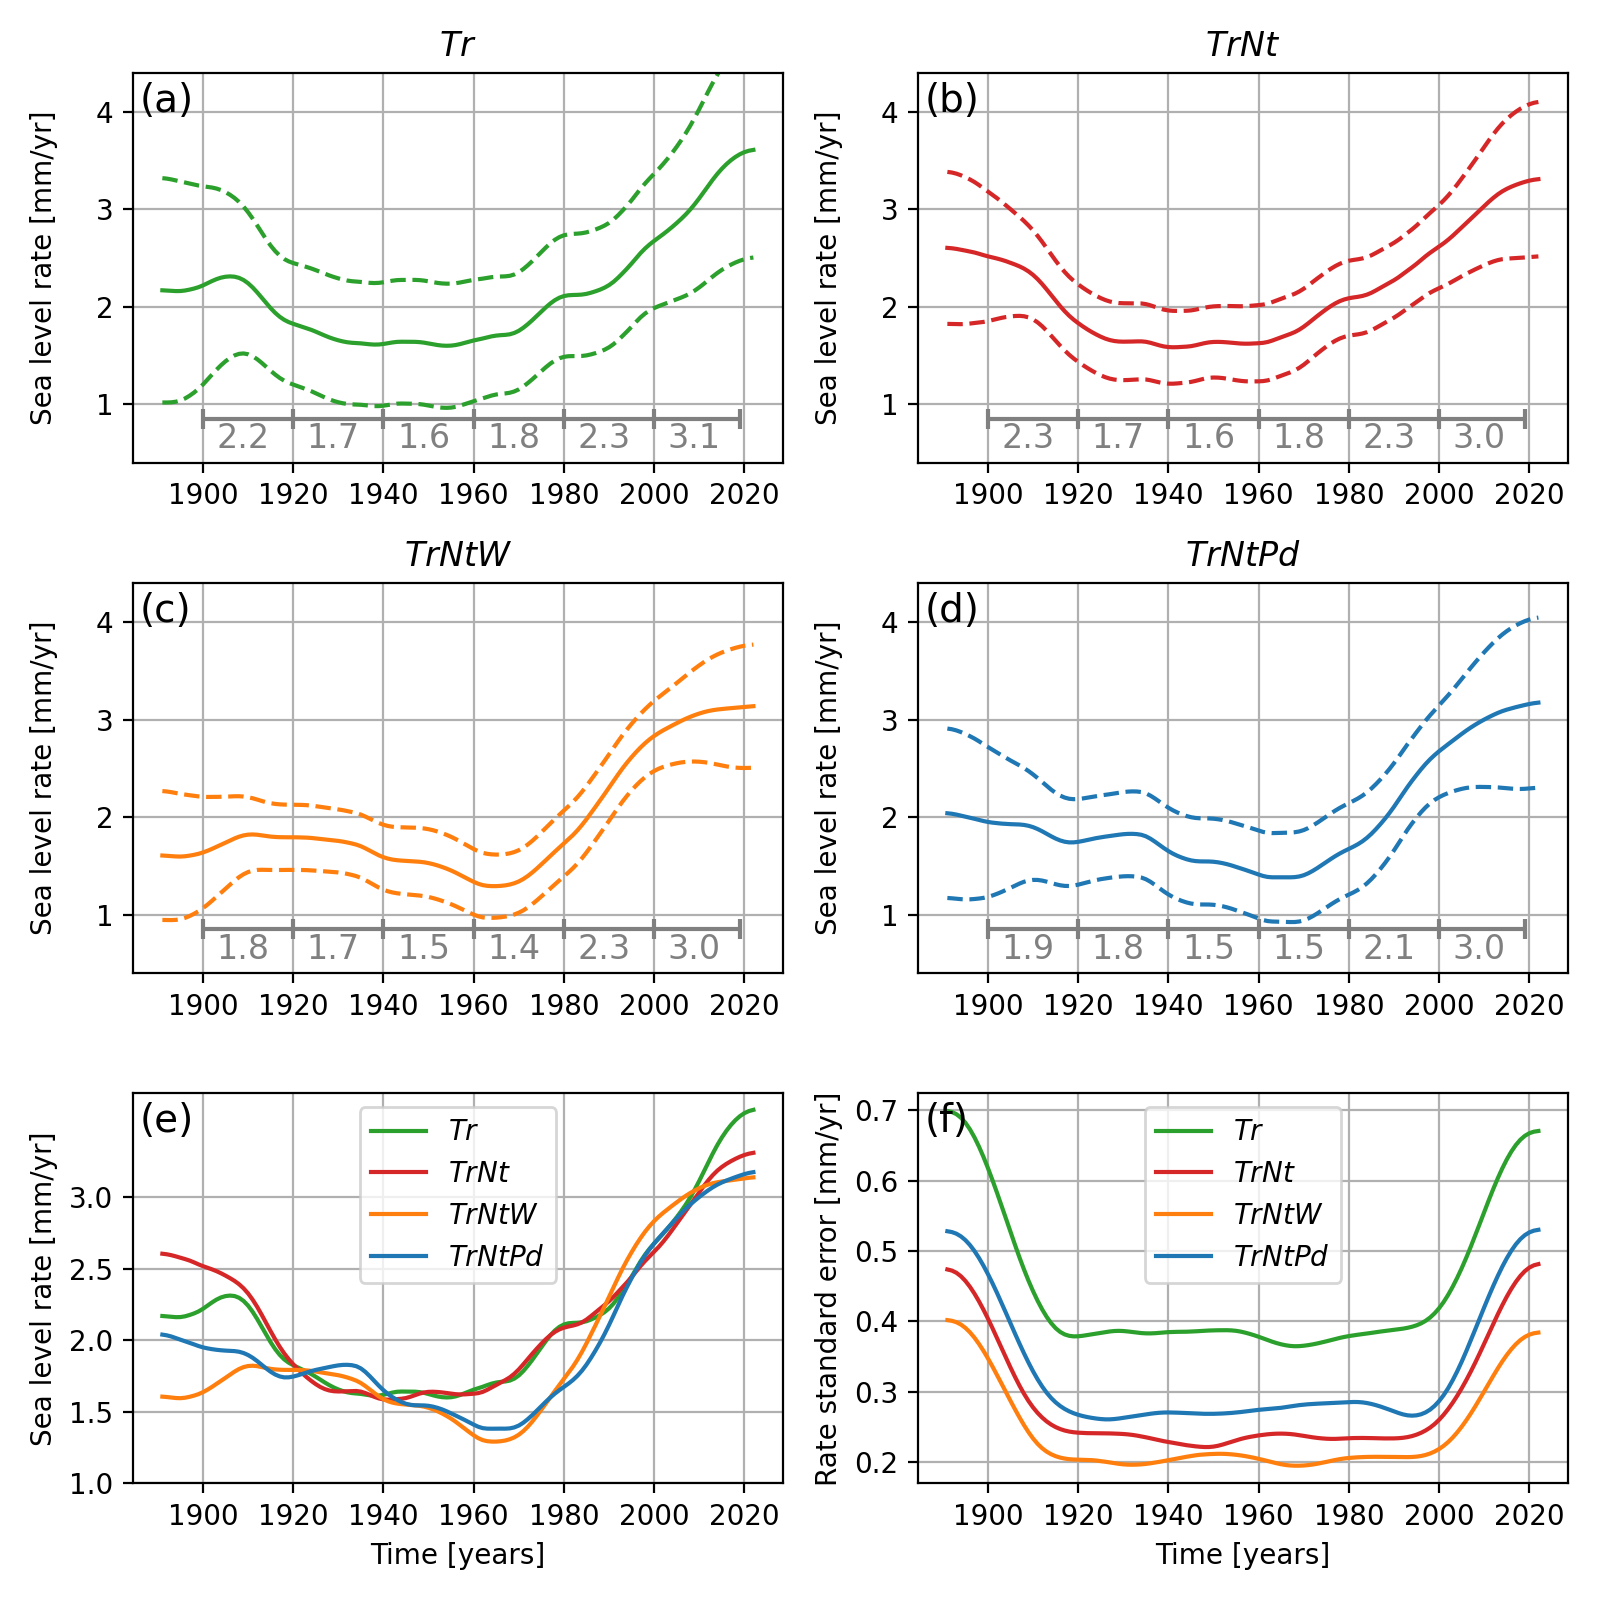

In [37]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]

fig, ax = plt.subplots(3, 2, figsize=(8,8))

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    
    res['0.5'].plot(ax=ax.flat[idx], title=short_names[idx], color=colors[idx])
    res['0.05'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    res['0.95'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    
    ax.flat[idx].set_xlabel('')
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([0.4, 4.4])
    # ax.flat[idx].grid(True)
    ax.flat[idx].text(0.01, 0.9, panels[idx], transform=ax.flat[idx].transAxes, 
                      size=14)
    
    ax.flat[idx].hlines(y=0.85, xmin=list_st[0], xmax=list_st[5]+19, 
                        color='grey', linestyle='-')
    #ax.flat[idx].hlines(y=0.85, xmin=list_st[5], xmax=list_st[5]+19, 
    #                    color='grey', linestyle='-')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
        ax.flat[idx].text(st+3, 0.55, avg_rate, size=12, color='grey')
        ax.flat[idx].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', 
                            linestyle='-')
    ax.flat[idx].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')

rates_q_nr['0.5'].plot(ax=ax.flat[4], color=colors[0], label=short_names[0])
rates_q_nt['0.5'].plot(ax=ax.flat[4], color=colors[1], label=short_names[1])
rates_q_na['0.5'].plot(ax=ax.flat[4], color=colors[2], label=short_names[2])
rates_q_pd['0.5'].plot(ax=ax.flat[4], color=colors[3], label=short_names[3])

ax.flat[4].set_ylabel('Sea level rate [mm/yr]')
ax.flat[4].set_yticks(np.arange(1,3.5,.5))
ax.flat[4].set_xlabel('Time [years]')
ax.flat[4].legend()
# ax.flat[4].grid(True)
ax.flat[4].text(0.01, 0.9, panels[4], transform=ax.flat[4].transAxes, size=14)

ser_nr.plot(ax=ax.flat[5], color=colors[0], label=short_names[0])
ser_nt.plot(ax=ax.flat[5], color=colors[1], label=short_names[1])
ser_na.plot(ax=ax.flat[5], color=colors[2], label=short_names[2])
ser_pd.plot(ax=ax.flat[5], color=colors[3], label=short_names[3])

ax.flat[5].set_ylabel('Rate standard error [mm/yr]')
ax.flat[5].set_xlabel('Time [years]')
ax.flat[5].legend()
# ax.flat[5].grid(True)
ax.flat[5].text(0.01, 0.9, panels[5], transform=ax.flat[5].transAxes, size=14)

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(np.arange(1900,2021,20))
        ax[i,j].grid(axis='x', which='major')
        ax[i,j].grid(axis='y', which='major')

fig.align_ylabels()
fig.tight_layout()
plt.savefig(f'./figures/{region}/{bootsize}/RateSeaLevelTrend.pdf', dpi=150)
plt.savefig(f'./figures/Fig4.pdf', dpi=150)

## Fig. A1: Nodal effects on sea level

In [38]:
nodal

,TrNc,TrNcW,TrNcPd,Equilibrium tide
time,,,,
1890,1.080432,1.175243,1.012923,-0.024364
1891,1.364234,1.382472,1.279873,0.157298
1892,1.494048,1.433655,1.402357,0.321200
1893,1.455220,1.323014,1.366550,0.448835
1894,1.252135,1.063037,1.176493,0.525791
...,...,...,...,...
2019,0.539993,0.716720,0.505130,-0.248446
2020,0.973126,1.088570,0.912061,-0.073809
2021,1.296416,1.337547,1.216042,0.109162


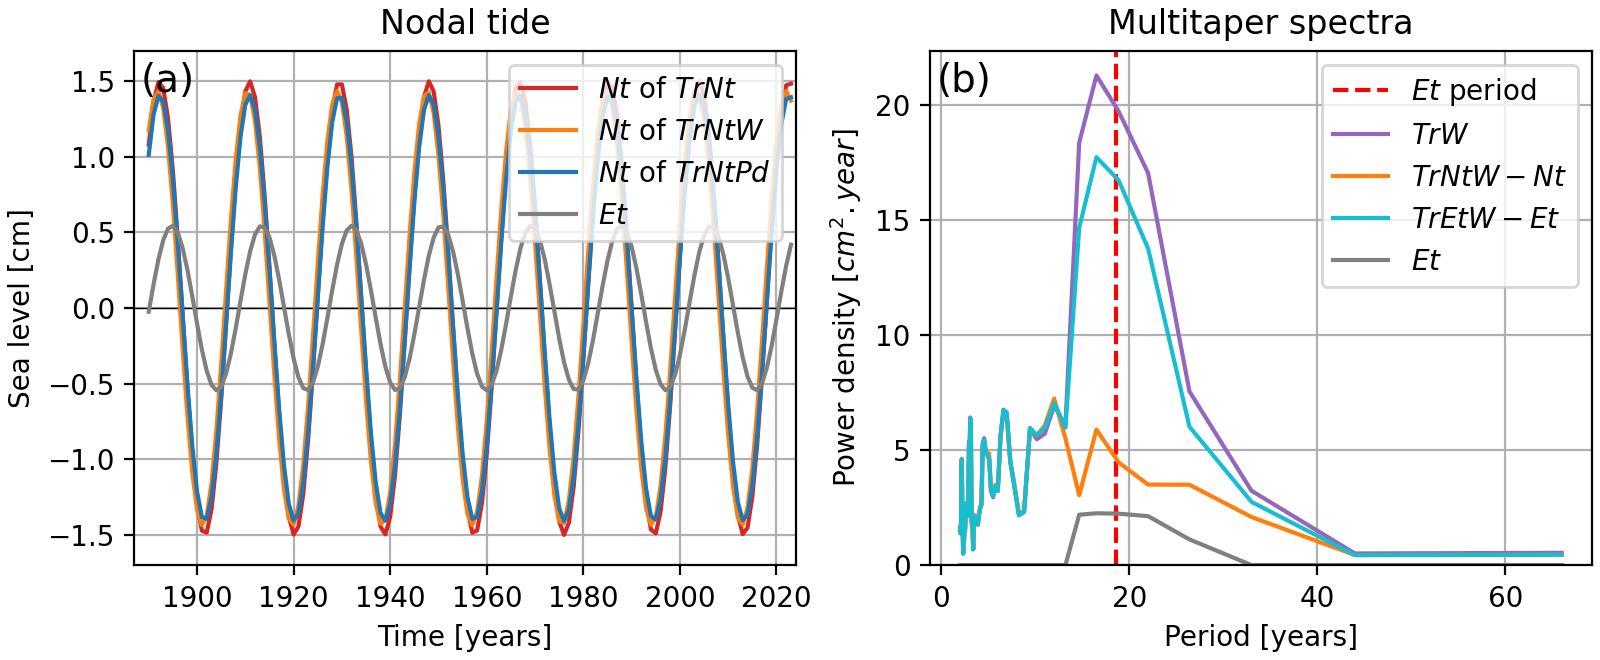

In [39]:
colors = ['tab:red', 'tab:orange', 'tab:blue', 'grey', 'tab:purple', 'tab:cyan']
labels = [r'$Nt$ of $TrNt$',r'$Nt$ of $TrNtW$',r'$Nt$ of $TrNtPd$',r'$Et$']

fig, ax = plt.subplots(1, 2, figsize=(8,3.3), constrained_layout=True) #14, 10

# Panel 1
ax[0].axhline(0, c='k', lw=.5)
for idx, data in enumerate(nodal):
    ax[0].plot(nodal.index, nodal[data], label=labels[idx], color=colors[idx])

ax[0].set_xlabel('Time [years]')
ax[0].set_ylabel('Sea level [cm]')
ax[0].set_title('Nodal tide')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-1.7,1.7)
ax[0].set_xlim((1887,2024))

# Panel 2
ax[1].axvline(18.613, c='r', label='$\it{Et}$ period', ls='--')

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['NearestPointAverageNoTide_dt'].values, 1)
ax[1].plot(1/xf_mtm[2:], yf_mtm[2:], label='$\it{TrW}$', color=colors[4])

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['NearestPointAverage2_dt'].values, 1)
ax[1].plot(1/xf_mtm[2:], yf_mtm[2:], label='$\it{TrNtW}-\it{Nt}$', color=colors[1])

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['EquilibriumTide_dt'].values, 1)
ax[1].plot(1/xf_mtm[2:], yf_mtm[2:], label='$\it{TrEtW}-\it{Et}$', color=colors[5])

xf_mtm, yf_mtm, _ = loc.mtm(nodal['Equilibrium tide'].values, 1)
ax[1].plot(1/xf_mtm[2:], yf_mtm[2:], label='$\it{Et}$', color=colors[3])

ax[1].legend()
ax[1].set_title('Multitaper spectra')
ax[1].set_ylabel('Power density '+r'$[cm^2.year]$')
ax[1].set_xlabel('Period [years]')

ax[1].set_yticks(np.arange(0,21,5))
ax[1].set_ylim((0, None))

for idx in range(2):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

# fig.tight_layout()

plt.savefig(f'./figures/{region}/NodalTide.pdf', dpi=150)
plt.savefig(f'./figures/FigA1.pdf', dpi=150)

## Fig. B1: Rates of SLR of individual tide gauges

In [40]:
stations = ['Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']
bootsize = 10000 # Choose from 100, 1000, 10000
model = 'NearestPointAverage2'

In [41]:
rates_q_tgstations = []
ser_tgstations = []

for station in stations:
    output_dir = f'./outputs/{station}/{bootsize}'
    rates_q_tgstations.append(pd.read_csv(f'{output_dir}/rates_quantiles_{model}.csv', index_col = 'time'))
    rates_tgstations = pd.read_csv(f'{output_dir}/rates_{model}.csv', index_col = 'time')
    ser_tgstations.append(rates_tgstations.std(axis=1))

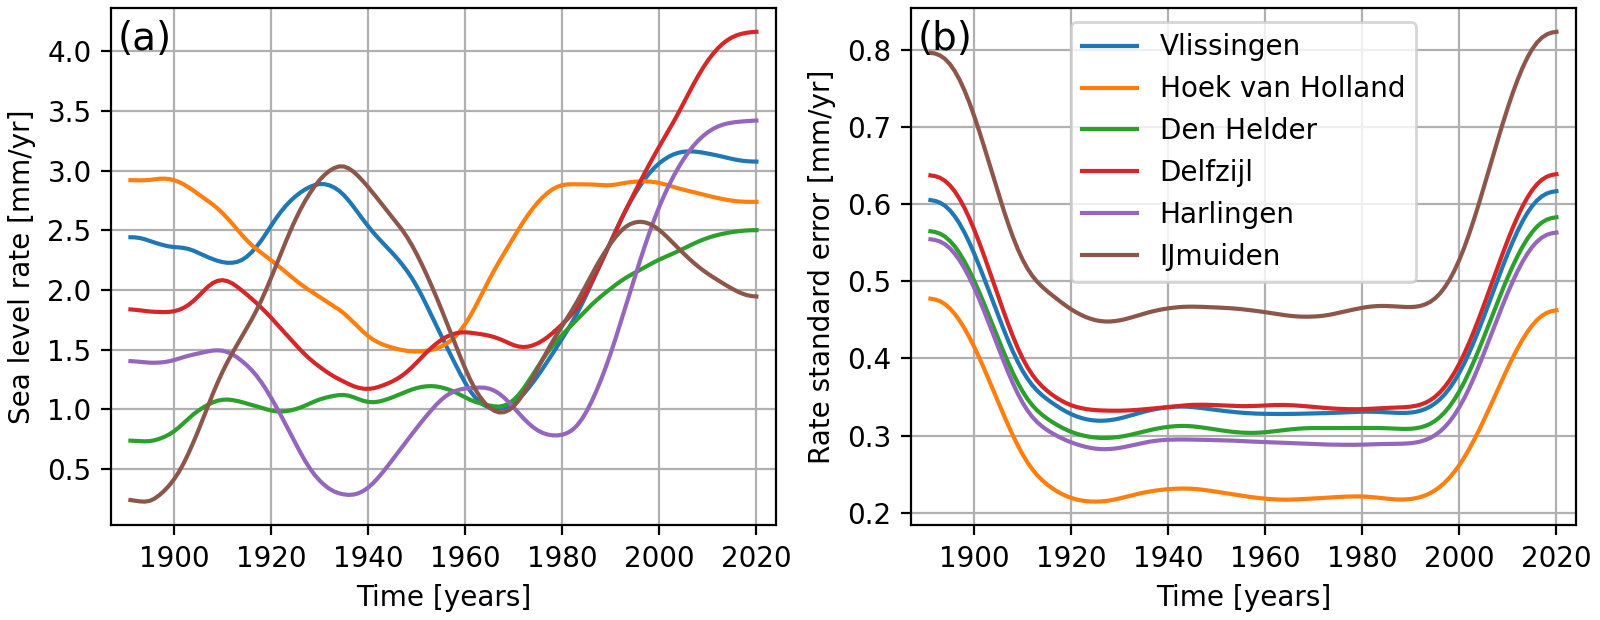

In [42]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]
fig, axs = plt.subplots(1, 2, figsize=(8,3.1), constrained_layout=True)

# Panel 1
for idx, station in enumerate(stations):
    axs[0].plot(rates_q_tgstations[idx].index, rates_q_tgstations[idx]['0.5'], label = station)
    
axs[0].set_xlabel('Time [years]')
axs[0].set_ylabel('Sea level rate [mm/yr]')
axs[0].grid()
axs[0].text(0.01, 0.92, panels[0], transform=axs[0].transAxes, size=14)

# Panel 2
for idx, station in enumerate(stations):
    axs[1].plot(ser_tgstations[idx].index, ser_tgstations[idx].values, label = station)

axs[1].set_xlabel('Time [years]')
axs[1].set_ylabel('Rate standard error [mm/yr]')
axs[1].legend()
axs[1].grid()
axs[1].text(0.01, 0.92, panels[1], transform=axs[1].transAxes, size=14)

for i in range(2):
    axs[i].set_xlim((1887,2024))


plt.savefig(f'./figures/RateSeaLevelTrendStations_{model}_{bootsize}.pdf', dpi=150)
plt.savefig(f'./figures/FigB1.pdf', dpi=150)

In [43]:
string = 'Mean uncertainty per station:\n'
for idx, station in enumerate(stations):
    string += f'{station}: {round(ser_tgstations[idx].mean(),2)}\n'
    
print(string)

Mean uncertainty per station:
Vlissingen: 0.39
Hoek van Holland: 0.28
Den Helder: 0.37
Delfzijl: 0.4
Harlingen: 0.35
IJmuiden: 0.54



## Fig. C1: Low-frequency wind influence on sea level

This figure is created in the notebook sst.ipynb

In [26]:
# correlation map
ds = xr.open_dataset('data/COBE-SST/cobe_sst.nc')
ds

<xarray.Dataset>
Dimensions:     (wind_model: 2, lat: 90, lon: 110)
Coordinates:
  * lon         (lon) float32 -99.5 -98.5 -97.5 -96.5 -95.5 ... 6.5 7.5 8.5 9.5
  * lat         (lat) float32 0.5 1.5 2.5 3.5 4.5 ... 85.5 86.5 87.5 88.5 89.5
  * wind_model  (wind_model) object 'NearestPointAverage2' 'PressureDifference'
Data variables:
    rmse        (wind_model, lat, lon) float64 ...
    r2          (wind_model, lat, lon) float64 ...
    r           (wind_model, lat, lon) float64 ...
    intercept   (wind_model, lat, lon) float64 ...
    reg_coef    (wind_model, lat, lon) float64 ...

/var/folders/m0/_pwjpvwj1sd92cdktdbp2bc00000gn/T/ipykernel_5228/544836093.py:29: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  f.canvas.draw()
/var/folders/m0/_pwjpvwj1sd92cdktdbp2bc00000gn/T/ipykernel_5228/544836093.py:34: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('figures/FigC1.png', dpi=600)
/opt/miniconda3/envs/NLSL/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

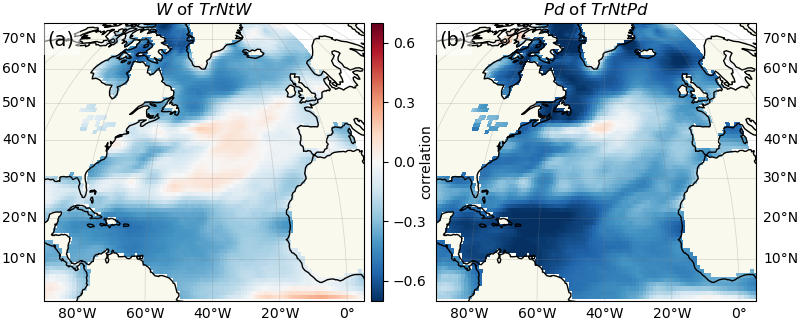

In [27]:
f = plt.figure(figsize=(8,3.3), constrained_layout=True)
# ax0 = f.add_axes([.01,.01,.98,.98])

for i in range(2):
    model = ['NearestPointAverage2','PressureDifference'][i]
    c = ['C1','C0'][i]
    ax1 = f.add_axes([.055+i*.49,.07,.4,.88], projection=ccrs.Mollweide(central_longitude=-40))
    ax1.set_extent([-90,5,0,70])
    ax1.set_title([r'$W$ of $TrNtW$',r'$Pd$ of $TrNtPd$'][i])

    map = plt.pcolormesh(ds.lon, ds.lat, ds.r.sel(wind_model=model),
                         transform=ccrs.PlateCarree(),
                         vmin=-.7, vmax=.7, cmap='RdBu_r')

    ax1.add_feature(cf.LAND, color='beige', alpha=.5)
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                       xlocs=np.arange(-160,180,20), ylocs=np.arange(-90,90,10),
                       linewidth=.5, color='gray', alpha=0.3
                       )

    if i==0: gl.right_labels = False
    else:    gl.left_labels  = False
    gl.top_labels = False

    props = {'facecolor':'white', 'alpha':0.5, 'linewidth':0}
    ax1.text(0.01, 0.92, f'({["a","b"][i]})', transform=ax1.transAxes, size=14, bbox=props)

f.canvas.draw()
pos = ax1.get_position()
cax = f.add_axes([0.464, pos.y0, 0.015, pos.y1-pos.y0])
cb = f.colorbar(map, cax=cax, orientation='vertical', ticks=np.arange(-.6,.7,.3))
cb.set_label('correlation', labelpad=-5)
plt.savefig('figures/FigC1.png', dpi=600)